In [1]:
# Common import

import os


import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report)

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam

from keras.models import Model
from keras.layers import Dense,Flatten
from keras.applications import vgg16
from keras import backend as K

from functools import reduce # for union of more than 2 arrays

from helper_functions import *



# This is simply an alias for convenience
layers = tf.keras.layers

#Fixing seed for reproducibility
np.random.seed(42)

C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fraca\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# Loading DataSet
local_data = './DataFiles/Mg22_alphaalpha_digiSim.h5'
hf = h5py.File(local_data, 'r')

# The function load_fata (helper_functions.py) performes the operation mentioned above.
DataList, Labels = load_data(hf)
hf.close() # closing file

Dataset contains 2000 events
Data contains 5 empty events, of indexes: [384, 430, 484, 914, 1204]

Dataset contains 1995 non-empty events:
995 Beam Events, and 1000 Reaction Events



In [3]:
# Create an ordered index list : [0,1,2,...,len(DataList)]
x_idx = np.arange(len(DataList))

# Splitting in train+validation (90% in total), and test (10%)
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)

# Splitting the remaining part (90% of the original DataSet): Training (90%) and Validation (10%)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)

print("Dataset was divided into:")
print(str(len(train_idx)) + " training events,")
print(str(len(val_idx)) + "  validation events, and")
print(str(len(test_idx)) + "  test events")

Dataset was divided into:
1615 training events,
180  validation events, and
200  test events


In [4]:
# Computing Features through the function calc_features (helper_functions.py)
(MeanXPerEvent, MeanYPerEvent, MeanZPerEvent, SumAPerEvent, 
PadsPerEvent, MeanWeightedXPerEvent, MeanWeightedYPerEvent, 
StDevXPerEvent, StDevYPerEvent, StDevZPerEvent,FracClosePtsPerEvent) = calc_features(DataList)

In [5]:
# Some definition before plotting 

# Splitting train_ind into beam and reaction indexes
train_r_idx = [] # List of indexes of "Reaction" training event
train_b_idx = [] # List of indexes of "Beam" training event

for i in train_idx:
    if Labels[i]>0.5:
        train_r_idx.append(i) # Indexes of "Reaction" training data
    else:
        train_b_idx.append(i) # Indexes of "Beam" training data
        
# Converting into numpy array for later use
train_r_idx = np.array(train_r_idx) 
train_b_idx = np.array(train_b_idx)

# Defining colours for histograms and scatter plot
b_color = 'black'
r_color = 'blue'

#Define legend for 2d (scatter)plots
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Beam', markerfacecolor=b_color, markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Reaction', markerfacecolor=r_color, markersize=15)]

Scatter Plots: X, Y, Z


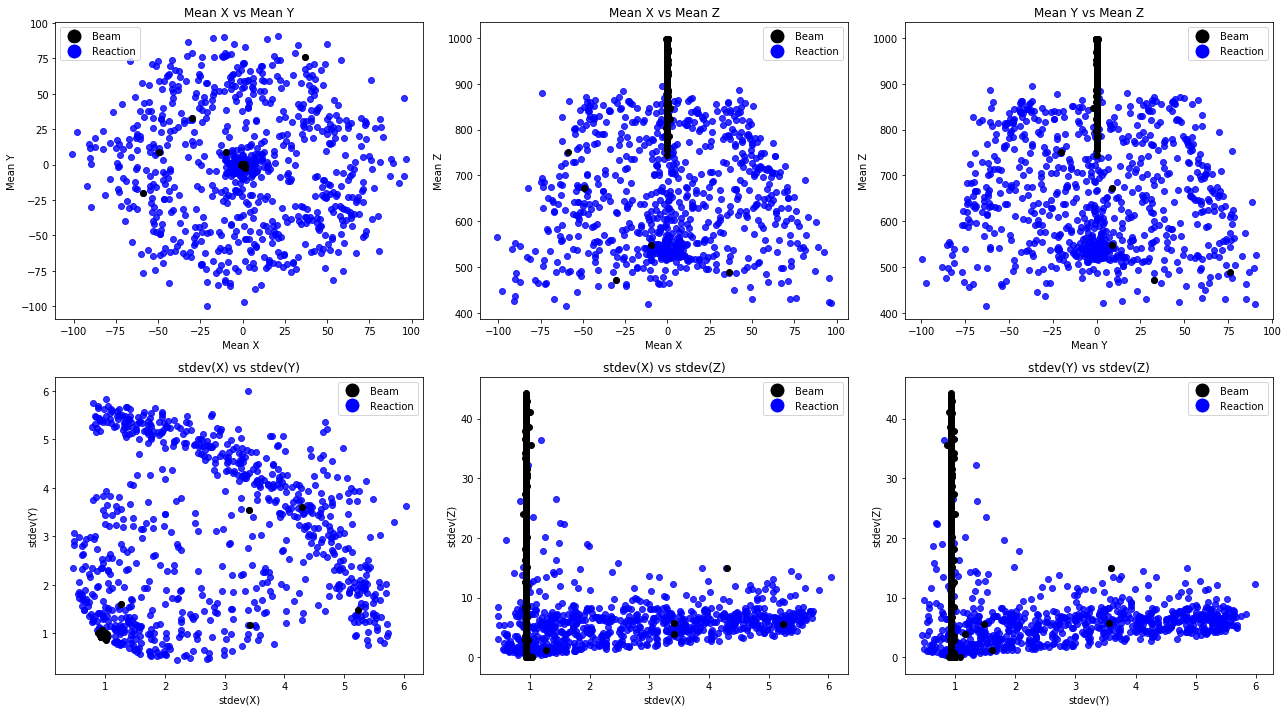

In [6]:
print("Scatter Plots: X, Y, Z")
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# Mean values
ax[0][0].scatter(MeanXPerEvent[train_r_idx],MeanYPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[0][0].scatter(MeanXPerEvent[train_b_idx],MeanYPerEvent[train_b_idx], c = b_color)
ax[0][0].set_title("Mean X vs Mean Y")
ax[0][0].set_xlabel(" Mean X")
ax[0][0].set_ylabel("Mean Y")
ax[0][0].legend(handles=legend_elements)

ax[0][1].scatter(MeanXPerEvent[train_r_idx],MeanZPerEvent[train_r_idx], c = r_color,  alpha=0.8)
ax[0][1].scatter(MeanXPerEvent[train_b_idx],MeanZPerEvent[train_b_idx], c = b_color)
ax[0][1].set_title("Mean X vs Mean Z")
ax[0][1].set_xlabel("Mean X")
ax[0][1].set_ylabel("Mean Z")
ax[0][1].legend(handles=legend_elements)

ax[0][2].scatter(MeanYPerEvent[train_r_idx],MeanZPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[0][2].scatter(MeanYPerEvent[train_b_idx],MeanZPerEvent[train_b_idx], c = b_color)
ax[0][2].set_title("Mean Y vs Mean Z")
ax[0][2].set_xlabel("Mean Y")
ax[0][2].set_ylabel("Mean Z")
ax[0][2].legend(handles=legend_elements)

# Standard Deviations
ax[1][0].scatter(StDevXPerEvent[train_r_idx],StDevYPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[1][0].scatter(StDevXPerEvent[train_b_idx],StDevYPerEvent[train_b_idx], c = b_color)
ax[1][0].set_title("stdev(X) vs stdev(Y)")
ax[1][0].set_xlabel("stdev(X)")
ax[1][0].set_ylabel("stdev(Y)")
ax[1][0].legend(handles=legend_elements)

ax[1][1].scatter(StDevXPerEvent[train_r_idx],StDevZPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[1][1].scatter(StDevXPerEvent[train_b_idx],StDevZPerEvent[train_b_idx], c = b_color)
ax[1][1].set_title("stdev(X) vs stdev(Z)")
ax[1][1].set_xlabel("stdev(X)")
ax[1][1].set_ylabel("stdev(Z)")
ax[1][1].legend(handles=legend_elements)

ax[1][2].scatter(StDevYPerEvent[train_r_idx],StDevZPerEvent[train_r_idx], c = r_color, alpha=0.8)
ax[1][2].scatter(StDevYPerEvent[train_b_idx],StDevZPerEvent[train_b_idx], c = b_color)
ax[1][2].set_title("stdev(Y) vs stdev(Z)")
ax[1][2].set_xlabel("stdev(Y)")
ax[1][2].set_ylabel("stdev(Z)")
ax[1][2].legend(handles=legend_elements)

fig.tight_layout()
plt.show()

In [7]:
xSimple = np.zeros((len(DataList),5)) # Design Matrix with 5 features

# Filling the matrix
for i in range(len(DataList)):
    xSimple[i][0] = MeanZPerEvent[i]
    xSimple[i][1] = StDevXPerEvent[i]
    xSimple[i][2] = FracClosePtsPerEvent[i]
    xSimple[i][3] = SumAPerEvent[i]
    xSimple[i][4] = PadsPerEvent[i]
# not used 
    #xSimple[i][0] = MeanXPerEvent[i]
    #xSimple[i][1] = MeanYPerEvent[i]
    #xSimple[i][1] = StDevYPerEvent[i]
    #xSimple[i][5] = StDevZPerEvent[i]

# Dividing entries in train, val and test
xSimple_train = xSimple[train_idx][:]
xSimple_val = xSimple[val_idx][:]
xSimple_test = xSimple[test_idx][:]
Labels_train = Labels[train_idx]
Labels_val = Labels[val_idx]
Labels_test = Labels[test_idx]

# Converting to DataFrame for better visualization, and for possible later use
X= pd.DataFrame(xSimple)
print("Design Matrix X:")
X.columns = ['Mean Z','stdev(X)','FCP','Total Q','Pads']
X

Design Matrix X:


,Mean Z,stdev(X),FCP,Total Q,Pads
0,961.083333,0.930198,1.000000,41292.864135,24.0
1,661.897436,5.692321,0.097436,322786.822798,195.0
2,877.083333,0.930198,1.000000,89094.206758,24.0
3,529.016129,0.646942,0.153226,168967.813590,124.0
4,938.916667,0.930198,1.000000,34598.337410,24.0
...,...,...,...,...,...
1990,485.930818,3.872534,0.062893,364154.705449,318.0
1991,817.750000,0.930198,1.000000,117215.746684,24.0
1992,526.930233,0.782013,0.418605,37851.885998,43.0
1993,940.083333,0.930198,1.000000,45542.970478,24.0


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(xSimple_train)

# Using the standardscaler
xSimple_train_stdsc = scaler.transform(xSimple_train)
xSimple_val_stdsc = scaler.transform(xSimple_val)

# Logistic Regression

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.69%
Precision : 99.38%
Recall    : 100.00%
F1-score  : 99.69%
MCC       : 99.38%


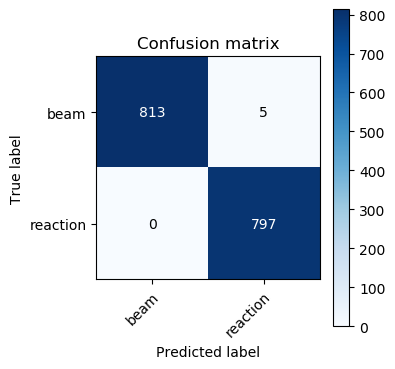


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 99.46%
MCC       : 98.89%


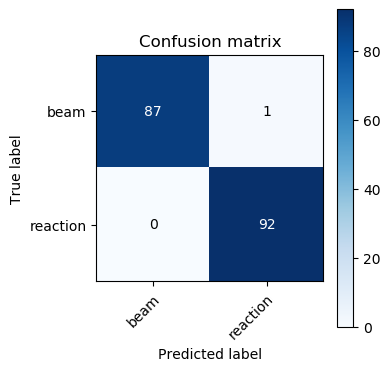

In [9]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(xSimple_train_stdsc, Labels_train)

LR_pred_train = logreg.predict(xSimple_train_stdsc)
LR_pred_val = logreg.predict(xSimple_val_stdsc)


print_model_performance(Labels_train,LR_pred_train,"Training")
print_model_performance(Labels_val,LR_pred_val,"Validation")

##  <span style="color:darkred">Random Forest</span>

The random forest method combines the output a number of decision trees to make predictions. Each decision tree 
uses nodes with if-then-else structured conditions on the features that end up in a classification. 

#### A simple decision tree
Decision trees are a type of model used for both classification and regression. Trees answer sequential questions which send us down a certain route of the tree given the answer. The model behaves with “if this than that” conditions ultimately yielding a specific result. You can see a simple tree displayed below.

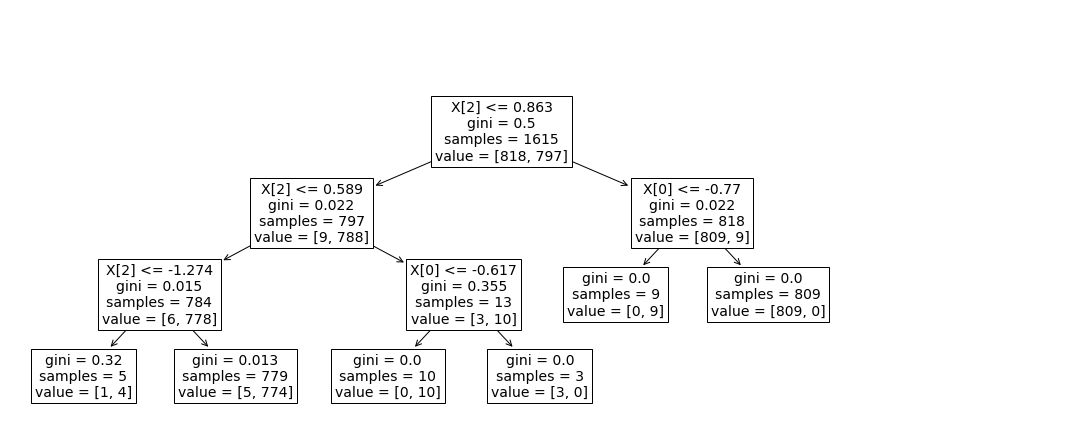

In [21]:
from sklearn import tree
DT = tree.DecisionTreeClassifier(max_depth=3)
DT = DT.fit(xSimple_train_stdsc, Labels_train)

# Better visualization of the tree
fig, ax = plt.subplots(figsize=(15, 6))
tree.plot_tree(DT, fontsize=14)

fig.tight_layout()
plt.show()


#### Decision Tree -----> Random Forest  
A random forest is simply a collection of decision trees whose results are aggregated into one final result. Their ability to limit overfitting without substantially increasing error due to bias is why they are such powerful models.  


Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.94%
Precision : 99.87%
Recall    : 100.00%
F1-score  : 99.94%
MCC       : 99.88%


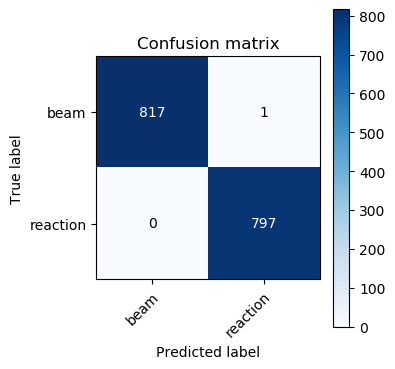


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 99.46%
MCC       : 98.89%


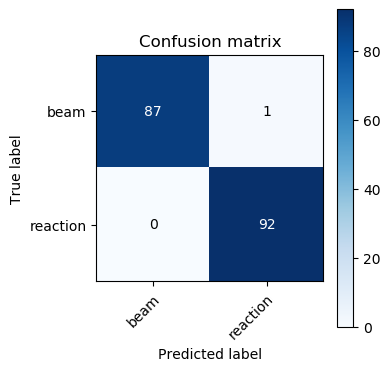

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Random forest with n_estimators trees, and usign max_features features
RFC = RandomForestClassifier(n_estimators = 5, max_features = 3)

RFC.fit(xSimple_train_stdsc, Labels_train)

RFC_pred_train = RFC.predict(xSimple_train_stdsc)
RFC_pred_val = RFC.predict(xSimple_val_stdsc)
print_model_performance(Labels_train,RFC_pred_train,"Training")
print_model_performance(Labels_val,RFC_pred_val,"Validation")

#### Random Forest with Grid Search  
To find the best random forest method, a gridsearch is performed with cross-validation on the training set. 

GridSearchCV is a library function that is a member of sklearn’s model_selection package. It helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters.

In our case we choose to tune over n_estimators, max_features, and bootstrap. 

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Grid Search, setting parameters
param_grid = [ {'n_estimators': [1,2,3,4,5], 'max_features': [2,3,4,5], 'bootstrap': [False,True]} ]
scoring = 'precision' # 'neg_mean_squared_error', 'accuracy', 'recall'

# Perform Grid Search on RFC
grid_search_imp = GridSearchCV(RFC, param_grid, cv=5, scoring=scoring)
# Loop on RFC for different hyper-parameters
grid_search_imp.fit(xSimple_train_stdsc, Labels_train)
cvres = grid_search_imp.cv_results_
feature_importances = grid_search_imp.best_estimator_.feature_importances_

# Printing Result Found through Grid Search
print(">>> Best Parameters:\n", grid_search_imp.best_params_)
print("")
print(">>> Best Estimetor:\n",grid_search_imp.best_estimator_)
print("")
print(">>> Importance of each feature: ")
print(sorted(zip(feature_importances, ["x","y","z","charge","nrofpads"]), reverse=True))

print(">>> Results for each set of parameters:")
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("Mean score: {:.2f}%".format(mean_score*100), params)


>>> Best Parameters:
 {'bootstrap': True, 'max_features': 3, 'n_estimators': 5}

>>> Best Estimetor:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

>>> Importance of each feature: 
[(0.7158340709673391, 'nrofpads'), (0.1960966970545212, 'z'), (0.07625634970160086, 'x'), (0.00873115690120187, 'y'), (0.0030817253753370024, 'charge')]
>>> Results for each set of parameters:
Mean score: 98.88% {'bootstrap': False, 'max_features': 2, 'n_estimators': 1}
Mean score: 99.12% {'bootstrap': False, 'max_features

Model performance for Training set:
--------------------------------------------------------
Accuracy  : 99.94%
Precision : 99.87%
Recall    : 100.00%
F1-score  : 99.94%
MCC       : 99.88%


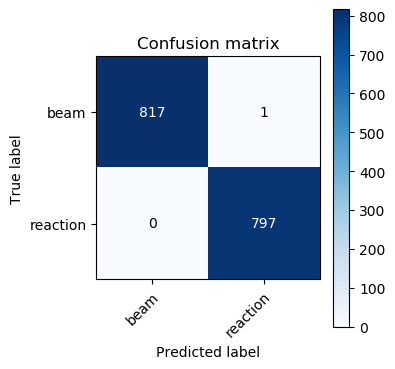


Model performance for Validation set:
--------------------------------------------------------
Accuracy  : 99.44%
Precision : 98.92%
Recall    : 100.00%
F1-score  : 99.46%
MCC       : 98.89%


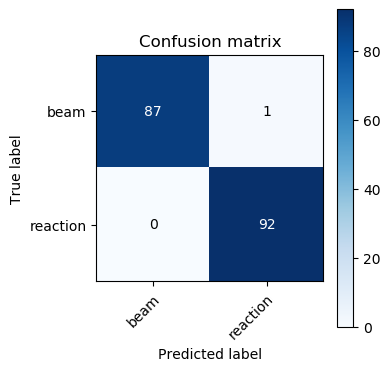

In [119]:
RFC_best = grid_search_imp.best_estimator_
RFC_pred_train = RFC_best.predict(xSimple_train_stdsc)
RFC_pred_val = RFC_best.predict(xSimple_val_stdsc)

# Printing Performances
print_model_performance(Labels_train,RFC_pred_train,"Training")
print_model_performance(Labels_val,RFC_pred_val,"Validation")

The best random forest estimator (found by grid search) reaches an
accuracy of over 99% on both training and validation set. Its results are very similar 
to the ones from the logistic regression. One could suspect the random forest estimator to overfit slightly,given its larger accuracy on the training set and the tendency for random forests to do so, 
but the limited size of the dataset prevents us from proving this. In case it does, one could also restrict the
'max_depth' of the trees to reduce overfitting.
